<!-- <h2>Title</h2> -->

---
<h1> 
    Digital Image Processing (APPM4058A & COMS7238A)<br><br>
    Assignment 2 
</h1>

--- 

Philani Mpofu: 1848751<br>

--- 


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import ndimage
from skimage.morphology import disk
from skimage.filters import threshold_otsu
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import imutils
from pathlib import Path
from numpy import linalg
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from itertools import chain
import scipy as sp
import glob
import math

## Question 1

Load the image.

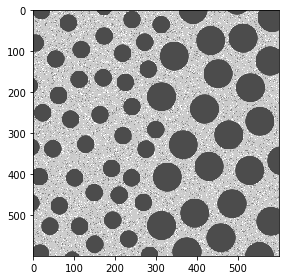

In [2]:
img = cv2.imread('images/blobs.tif')
io.imshow(img, cmap=plt.cm.gray)

The following cell initializes 3 processing elements. **circular_element1** stores the first circular processing element, **circular_element2** stores the second processing element and **square_kernel** stores the square processing element (in this case it is a 3x3 matrix of ones).

In [3]:
circular_element1 = selem = disk(30)
circular_element2 = disk(60)
square_kernel = np.ones((3,3),np.uint8)

The next cell computes the closing of the image with the first circular processing element. Following that, the opening of the closed image is computed using the second circular processing element. 

In [4]:
closing_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, circular_element1)
opening_img = cv2.morphologyEx(closing_img, cv2.MORPH_OPEN, circular_element2)

The following cell computes a gradient that is used to extract the boundary between the two regions in the loaded image.

In [5]:
gradient = cv2.morphologyEx(opening_img, cv2.MORPH_GRADIENT, square_kernel)
solution_img = cv2.add(img, gradient)

Display the original image alongside the solution image (ie: The image with a boundary between the two regions using suitable morphological approaches). 

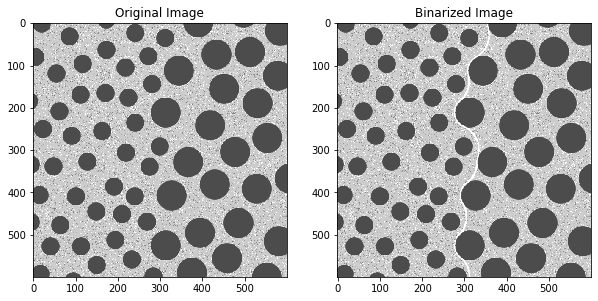

In [6]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

fig.add_subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')

fig.add_subplot(1,2,2)
plt.title("Binarized Image")
plt.imshow(solution_img, cmap='gray')

## Question 2

Load the image.

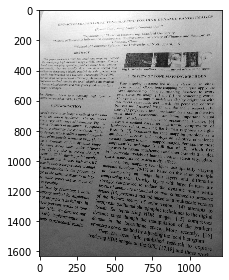

In [7]:
img = cv2.imread('images/page.png', cv2.IMREAD_GRAYSCALE)
io.imshow(img, cmap=plt.cm.gray)

The following cell initializes the **threshold** and **binary** values used to perform thresholding to binarize the image.

In [8]:
threshold = threshold_otsu(img)
binary = img > threshold

The following cell initializes the **block** and segments the image. 

In [9]:
block = (int)(1/10*1216/2+1)
block = int(block)

if block <= 1:
    block = 1216/2+1
    block = int(block)
    
const = 10
binarized_img = cv2.adaptiveThreshold(img,maxValue = 255, adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, 
                                        thresholdType = cv2.THRESH_BINARY, blockSize = block, C = const)

Display the solution image (ie: The binarized image) alongside the original image.

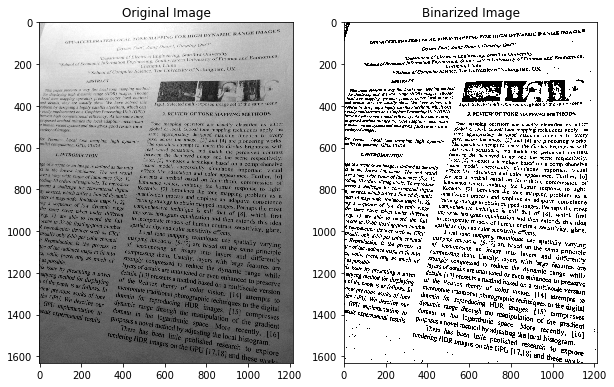

In [10]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

fig.add_subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')

fig.add_subplot(1,2,2)
plt.title("Binarized Image")
plt.imshow(binarized_img, cmap='gray')

## Question 3

Load the image as a grayscale image.

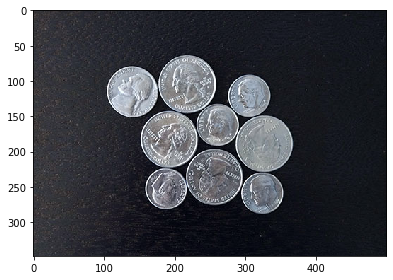

In [11]:
img = cv2.imread("images/coins_color.jpg")
io.imshow(img, cmap=plt.cm.gray)

The following cell computes the pyramid mean shift filter of the loaded image and then displays the computed image. This is done to achieve good results when thresholding methods are implemented in later sections.

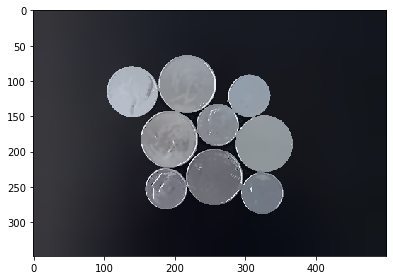

In [12]:
pyramid_mean_shift_img = cv2.pyrMeanShiftFiltering(img, 21, 51)
io.imshow(pyramid_mean_shift_img, cmap=plt.cm.gray)

The following cell convert the pyramid mean shifted image to a grayscale format.

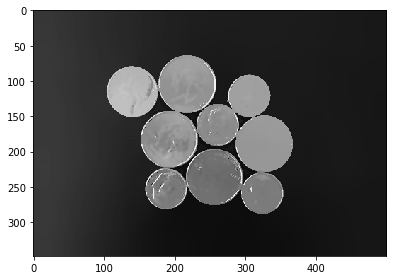

In [13]:
gray_img = cv2.cvtColor(pyramid_mean_shift_img, cv2.COLOR_BGR2GRAY)
io.imshow(gray_img)

The following cell thresholds the gray scale image using Otsu's thresholding.

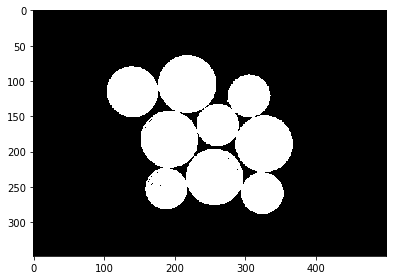

In [14]:
threshold_img = cv2.threshold(gray_img, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
io.imshow(threshold_img)

The next cell computes the unique targets of the image using the watershed algorithm. Follwoing this step, we loop over every pixel in the image. If the pixel is zero, then it is ignored. If it is not zero, then we calculate the contour. The highest contour values are then coloured in.

In [15]:
Distance = ndimage.distance_transform_edt(threshold_img)
local_maximum = peak_local_max(Distance, indices=False, min_distance=20,labels=threshold_img)
markers = ndimage.label(local_maximum, structure=np.ones((3, 3)))[0]
targets = watershed(-Distance, markers, mask=threshold_img)

for label in np.unique(targets):
    if label == 0:
        continue

    mask = np.zeros(gray_img.shape, dtype="uint8")
    mask[targets == label] = 255

    contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 2)

Display the solution image (ie: The image with the coins separated).

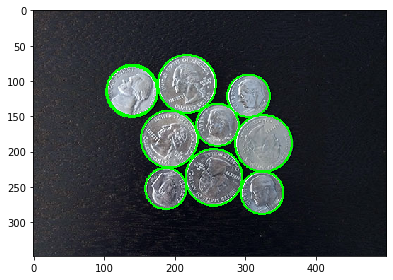

In [16]:
io.imshow(img, cmap=plt.cm.gray)

## Question 4

This sections has two functions with the purpose of solving this task. The first one calculates the angle at which to rotate the image and the other corrects the skewness of the image.

Load the image and store its dimensions in the **height** and **width** variables. 

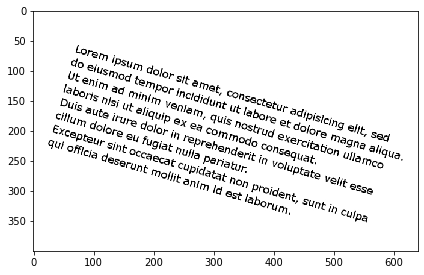

In [17]:
img = io.imread("images/skewed_text.png")
height, width = img.shape[0:2]
io.imshow(img, cmap=plt.cm.gray)

The following cell defines a function **get_theta** that calculates the angle at which to rotate the image. 

In [18]:
def get_theta(img):
    cv2.bitwise_not(img, img) # Invert the colors of the input image
    
    # Perform Hough Transformation and compute the angle between each line and the horizontal line
    min_length = width/2.0
    max_gap = 20
    Hough_lines = cv2.HoughLinesP(img,1,math.pi/180,100,min_length,max_gap)

    theta = 0.0
    nb_lines = len(Hough_lines)
    
    for line in Hough_lines:
        theta = theta + math.atan2(line[0][3]*1.0 - line[0][1]*1.0,line[0][2]*1.0 - line[0][0]*1.0);
    theta = theta/nb_lines*1.0
    theta = theta * 180.0 / math.pi
    return theta

The following cell defines a function **skew_correction** that uses the calculated angle to correct the skewness of the image.

In [19]:
def skew_correction(img, angle):
    
    cv2.bitwise_not(img, img) # Invert the colors of the input img
    
    # Compute the minmum bounding box and remove the borders 
    non_black_pixels = cv2.findNonZero(img)
    centre, wh, theta = cv2.minAreaRect(non_black_pixels)
    
    root_matrix = cv2.getRotationMatrix2D(centre, angle, 1)
    rows, columns = img.shape
    rotation = cv2.warpAffine(img, root_matrix, (columns, rows), flags=cv2.INTER_CUBIC)

    size_rows = np.int0(wh[0])
    size_columns = np.int0(wh[1])

    return cv2.getRectSubPix(rotation, (size_columns,size_rows), centre)

The following cell runs the recently defined functions to fix the skewness of the image.

In [20]:
theta = get_theta(img)
solution_img = skew_correction(img, theta)

Display the original image alongside the solution image (ie: the image skewness has been corrected).

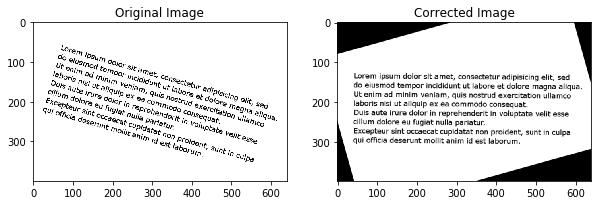

In [21]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

fig.add_subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')

fig.add_subplot(1,2,2)
plt.title("Corrected Image")
plt.imshow(solution_img, cmap='gray')

## Question 5

### (a)  Compute the eigenfaces

Load the dataset.

In [22]:
# Get the path of the image att_faces_aligned folder.
mypath = Path(r"C:\Users\Philani\Documents\Wits University\YOS 4\Semester 1\Digital Image Processing\Assignments\DIP_assignment2_1848751\images\att_faces_aligned")

# Store all of the images in an images list named gamma.
gamma = []

# Go through each directory and store the images in that directory in the gamma list.
for subdir in mypath.iterdir():
    gamma.append([io.imread(str(curfile)) for curfile in subdir.glob('*.pgm')])
    
# Convert the list to an array to have access to built-in np functions.
gamma = np.array(gamma)
print("Dimensions of gamma array: ", gamma.shape)

Dimensions of gamma array:  (40, 10, 112, 92)


The images of the have been correctly loaded. The **gamma** array contains facial images of 40 classes (persons), where each class has 10 images and each image has the dimensions (112 x 92).

Display the 10 pictures of the first person in the dataset.

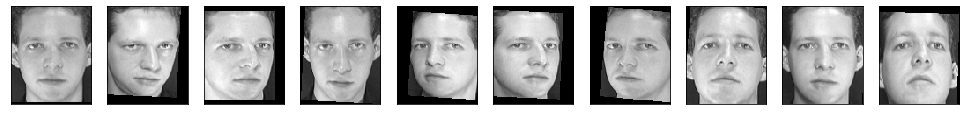

In [23]:
fig = plt.figure(figsize=(17, 17))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(gamma[0][i], cmap=plt.cm.gray)

### 1. Compute the average (or mean) face vector $Ψ$ for each person in the dataset.

In [24]:
psi = np.average(gamma, axis=1)
print("Dimensions of the average(mean) face vector Ψ: ", psi.shape)

Dimensions of the average(mean) face vector Ψ:  (40, 112, 92)


Display the average face image of the first person in the dataset. 

C:\Users\Philani\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


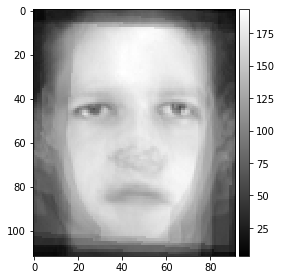

In [25]:
io.imshow(psi[0], cmap=plt.cm.gray)

Display the average face of the first 10 people in the dataset.

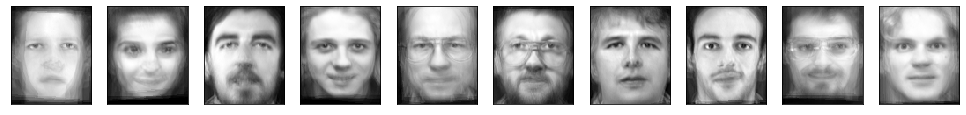

In [26]:
fig = plt.figure(figsize=(17, 17))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(psi[i], cmap=plt.cm.gray)

Display the average face of all of the people in the dataset (ie: the average face of all of the average faces).

Dimensions of the average_face:  (112, 92)


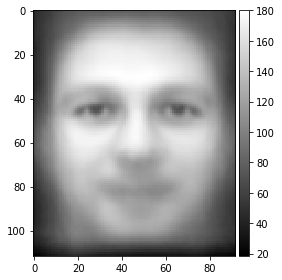

In [27]:
average_face = np.average(psi, axis=0)
print("Dimensions of the average_face: ", average_face.shape)
io.imshow(average_face, cmap=plt.cm.gray)

### 2. Display the top ten eigenfaces in two rows with each row containing 5 of them

First the dataset is reloaded into a more appropriate format that will work better with built-in functions to achieve this task.

In [28]:
curfile = [img for img in glob.glob('images/att_faces_aligned/*/*.pgm')]
gamma = [[] for i in range(400)]
for i in range(400):
    gamma[i] = list(chain.from_iterable(io.imread(curfile[i])))
gamma = np.array(gamma)
print("Dimensions of gamma array: ", gamma.shape)

Dimensions of gamma array:  (400, 10304)


Now **gamma** is reshaped into a (400 x 10304) array with each row containing all the information about a specific (112 x 92) image.

Fit a PCA model with **n_components** $=$ 10 to get the 10 most important eigenfaces.

In [29]:
pca = PCA(n_components=10, svd_solver='randomized', whiten=True).fit(gamma)

Display the top 10 eigenfaces in 2 rows with each row containing 5 of eigenfaces.

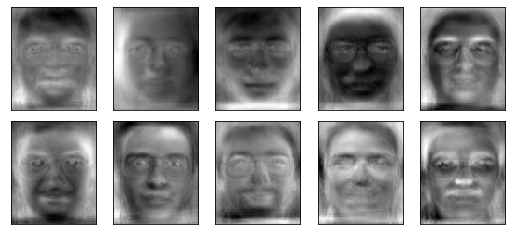

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(9, 4), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(112, 92), cmap=plt.cm.gray)

Essentially, in the above cell we generated an orthogonal basis such that each eigenface highlights a certain type of feature found in the dataset. Different combinations and proportions of these eigenfaces can be used to reconstruct the original faces in the dataset.

### (b) Face identification

There is a lot of lost data in a compressed vector space and that is why the eigenfaces are unrecorgnizable. In the following cell, is a built-in function that projects $Φ$ on the eigenspace (in this case $Φ$ is an image in $Γ$ subtracted by the mean face. Furthermore, $Φ$ is represented  as the coefficient vector $Ω$ obtained in the eigenspace. 

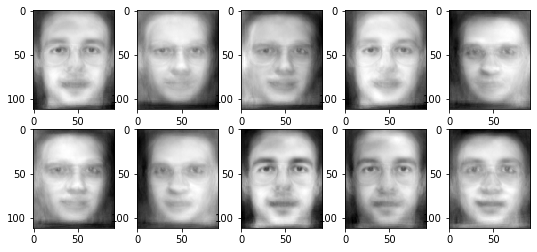

In [31]:
identify_faces = PCA(n_components=10)
identify_faces.fit(gamma)
    
components = identify_faces.transform(gamma)
projection = identify_faces.inverse_transform(components)

fig, axes = plt.subplots(2,5,figsize=(9,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(projection[i].reshape(112,92),cmap="gray")

As you can see, the faces in the projection array are more recorgnizable and can be identified as a person in $Γ$.